# Hyperparameter Optimization
Hyperparameters dictate the parameters of the training process and the architecture of the model itself. For example, the 
number of random trees is a hyperparameter for a **random forest**. In contrast, a learned parameter for a **random forest** is the set of features that is contained in a single node (in a single tree) and the cutoff values for each of those features that determines how the data is split at that node. A full discussion of hyperparameter optimization can be found on **[Wikipedia](https://en.wikipedia.org/wiki/Hyperparameter_optimization)**.

The choice of hyperparameters strongly influences model performance,
so it is important to be able to optimize them as well. **[AMPL](https://github.com/ATOMScience-org/AMPL)**
offers a variety of hyperparameter optimization methods including
random sampling, grid search, and Bayesian optimization. Please refer to the parameter documentation 
**[page](https://github.com/ATOMScience-org/AMPL#hyperparameter-optimization)** for further information.

In this tutorial we demonstrate the following:
- Build a parameter dictionary to perform a hyperparameter search for a **random forest** using Bayesian optimization.
- Perform the optimization process.
- Review the results

We will use these **[AMPL](https://github.com/ATOMScience-org/AMPL)** functions:
- [parse_params](https://ampl.readthedocs.io/en/latest/utils.html#utils.hyperparam_search_wrapper.parse_params)
- [build_search](https://ampl.readthedocs.io/en/latest/utils.html#utils.hyperparam_search_wrapper.build_search)
- [run_search](https://ampl.readthedocs.io/en/latest/utils.html#utils.hyperparam_search_wrapper.HyperOptSearch.run_search)
- [get_filesystem_perf_results](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.compare_models.get_filesystem_perf_results)

The first three functions in the above list come from the `hyperparameter_search_wrapper` module. 

## Set Up Directories

Here we set up a few important variables corresponding to required directories and specific features for the **hyperparameter optimization (HPO)** process. Then, we ensure that the directories are created before saving models into them.

|Variable|Description|
|---|---|
|`dataset_key`|The relative path to the dataset you want to use for HPO|
|`descriptor_type`|The type of features you want to use during HPO|
|`model_dir`|The directory where you want to save all of the models|
|`best_model_dir`|For Bayesian optimization, the winning model is saved in this separate folder|
|`split_uuid`|The presaved split uuid from **Tutorial 2, "Splitting Datasets for Validation and Testing"**|

In [20]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
import os

meas='ROS'
dataset_key='/Users/echun/repos/DILI/datasets/training_data/ROS_hits_up_class_curMoe.csv'
descriptor_type = 'moe' 
split_uuid = 'fd736690-ebf6-49fc-989e-87f654374d95'

model_dir = f'{meas}_models'
best_model_dir = f'{meas}_models/best_models'


# for meas in ['CellCount','MitoStruct','ROS','GSH','NucMask','NucArea','MMP','MT']:
#     if meas!="MT":
#         model_dir = f'ST_models/{meas}_models'
#         best_model_dir = f'ST_models/{meas}_models/best_models'
#     else:
#         model_dir = f'{meas}_models'
#         best_model_dir = f'{meas}_models/best_models'

#     if not os.path.exists(f'./{model_dir}'):
#         os.makedirs(f'./{model_dir}')

#     if not os.path.exists(f'./{best_model_dir}'):
#         os.makedirs(f'./{best_model_dir}')

To run a hyperparameter search, we first create a parameter dictionary with parameter settings that will be common to all models, along with some special parameters that control the search and indicate which parameters will be varied and how. The table below describes the special parameter settings for our random forest search.

## Parameter Dictionary Settings

|Parameter|Description|
|---|---|
|`'hyperparam':'True'`|This setting indicates that we are performing a hyperparameter search instead of just training one model.|
|`'previously_featurized':'True'`|This tells **[AMPL](https://github.com/ATOMScience-org/AMPL)** to search for previously generated features in `../dataset/scaled_descriptors` instead of regenerating them on the fly.|
|`'search_type':'hyperopt'`|This specifies the hyperparameter search method. Other options include `grid`, `random`, and `geometric`. Specifications for each hyperparameter search method is different, please refer to the full documentation. Here we are using the Bayesian optimization method.|
|`'model_type':'RF\|10'`|This means **[AMPL](https://github.com/ATOMScience-org/AMPL)** will try 10 times to find the best set of hyperparameters using **random forests**. In practice, this parameter could be set to 100 or more.|
|`'rfe':'uniformint\|8,512'`|The Bayesian optimizer will uniformly search between 8 and 512 for the best number of random forest estimators. Similarly `rfd` stands for **random forest depth** and `rff` stands for **random forest features**.|
|`result_dir`|Now expects two parameters. The first directory will contain the best trained models while the second directory will contain all models trained in the search.|

Regression models are optimized to maximize the $R^2$ and
classification models are optimized using area under the 
receiver operating characteristic curve.
A full list of parameters can be found on our
**[github](https://github.com/ATOMScience-org/AMPL/blob/master/atomsci/ddm/docs/PARAMETERS.md)**.

In [9]:
rf_params = {
    "hyperparam": "True",
    "prediction_type": "classification",

    "dataset_key": dataset_key,
    "id_col": "compound_id",
    "smiles_col": "base_rdkit_smiles",
    "response_cols": f"active",

    "splitter":"scaffold",
    "split_uuid": split_uuid,
    "previously_split": "True",

    "featurizer": "computed_descriptors",
    "descriptor_type" : "rdkit_raw", #"rdkit_raw", # "mordred_filtered", "chemberta"
    "transformers": "True",
    "previously_featurized": "True",

    "search_type": "hyperopt",
    "model_type": "RF|100",
    "rfe": "uniformint|8,512",
    "rfd": "uniformint|6,32",
    "rff": "uniformint|8,200",

    "weight_transform_type": "balancing",

    "result_dir": f"./{best_model_dir},./{model_dir}"
}

## Run Hyperparameter Search
In **Tutorial 3, "Train a Simple Regression Model"**, we directly imported the `parameter_parser` and `model_pipeline` objects to parse the `config` dict and train a single model. Here, we use `hyperparameter_search_wrapper` to handle many models for us. First we build the search by creating a list of parameters to use, and then we run the search.

In [ ]:
import atomsci.ddm.utils.hyperparam_search_wrapper as hsw
import importlib
importlib.reload(hsw)
# ampl_param = hsw.parse_params(params)
# hs = hsw.build_search(ampl_param)
# hs.run_search()

for params in [
    # rf_params,
    # xg_params,
    nn_params,
    ]:
    for meas in [
        # 'CellCount',
        # 'MitoStruct',
        'ROS',
        # 'GSH',
        # 'NucMask',
        # 'NucArea',
        # 'MMP'
        # 'MT'
        ]:
        params['response_cols'] = "active"
        # response_col = 'active_MMP,active_CellCount,active_MitoStruct,active_ROS,active_GSH,active_NucMask,active_NucArea'
        # params['response_cols'] = response_col
        params["result_dir"]=f"./ST_models2/{meas}_models/best_models,./ST_models2/{meas}_models"
        ampl_param = hsw.parse_params(params)
        hs = hsw.build_search(ampl_param)
        hs.run_search()

The top scoring model will be saved in `dataset/SLC6A3_models/best_models` along with a csv file
containing regression performance for all trained models.

All of the models are saved in `dataset/SLC6A3_models`. These models can be
explored using `get_filesystem_perf_results`. A full analysis of the hyperparameter performance is explored in **Tutorial 6, "Compare models to select the best hyperparameters"**.

In [23]:
import atomsci.ddm.pipeline.compare_models as cm

model_dir = f'./ST_models2/ROS_models'

result_df = cm.get_filesystem_perf_results(
    result_dir = model_dir,
    pred_type='classification'
)

# print(result_df.columns.tolist())


# sort by validation r2 score to see top performing models
result_df = result_df.sort_values(by='best_valid_roc_auc_score', ascending=False)
result_df[['model_uuid','model_parameters_dict','best_valid_roc_auc_score','best_test_roc_auc_score']].head()

# import pandas as pd
# pd.set_option('display.max_colwidth', None)
# result_df[['model_uuid','model_parameters_dict']].head()

Found data for 400 models under ./ST_models2/ROS_models


,model_uuid,model_parameters_dict,best_valid_roc_auc_score,best_test_roc_auc_score
80,74a05274-e413-4e9d-8246-f14bd4141dd3,"{""best_epoch"": 48, ""dropouts"": [0.369310177580...",0.762583,0.558497
207,a08feb85-02e4-4a70-80ea-54a4b444382c,"{""best_epoch"": 53, ""dropouts"": [0.021446071761...",0.759892,0.508497
296,0b40d4c3-7d4e-4514-832f-bfb19cdba4c4,"{""best_epoch"": 58, ""dropouts"": [0.088539053892...",0.759101,0.562092
237,d86b502e-7761-4a7f-85ed-53b5f5751cc0,"{""best_epoch"": 39, ""dropouts"": [0.175890332954...",0.753720,0.559641
233,3cb71d5c-97a3-443b-a1f0-4183ec4cc159,"{""best_epoch"": 59, ""dropouts"": [0.152069038098...",0.753403,0.609477


In [24]:
from atomsci.ddm.pipeline import compare_models as cm
from atomsci.ddm.pipeline import hyper_perf_plots as hpp
from atomsci.ddm.pipeline import perf_plots as pp
import pandas as pd
pd.set_option('display.max_columns', None)

# ignore warnings in tutorials
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [25]:
result_df=result_df.sort_values('best_valid_roc_auc_score', ascending=False)
print(result_df.shape)

# show useful columns 
result_df[['model_uuid', 'split_uuid', 'best_train_roc_auc_score', 'best_valid_roc_auc_score', 'best_test_roc_auc_score']].head()


(400, 70)


,model_uuid,split_uuid,best_train_roc_auc_score,best_valid_roc_auc_score,best_test_roc_auc_score
80,74a05274-e413-4e9d-8246-f14bd4141dd3,fd736690-ebf6-49fc-989e-87f654374d95,0.928695,0.762583,0.558497
207,a08feb85-02e4-4a70-80ea-54a4b444382c,fd736690-ebf6-49fc-989e-87f654374d95,0.875625,0.759892,0.508497
296,0b40d4c3-7d4e-4514-832f-bfb19cdba4c4,fd736690-ebf6-49fc-989e-87f654374d95,0.912988,0.759101,0.562092
237,d86b502e-7761-4a7f-85ed-53b5f5751cc0,fd736690-ebf6-49fc-989e-87f654374d95,0.936771,0.753720,0.559641
233,3cb71d5c-97a3-443b-a1f0-4183ec4cc159,fd736690-ebf6-49fc-989e-87f654374d95,0.788367,0.753403,0.609477


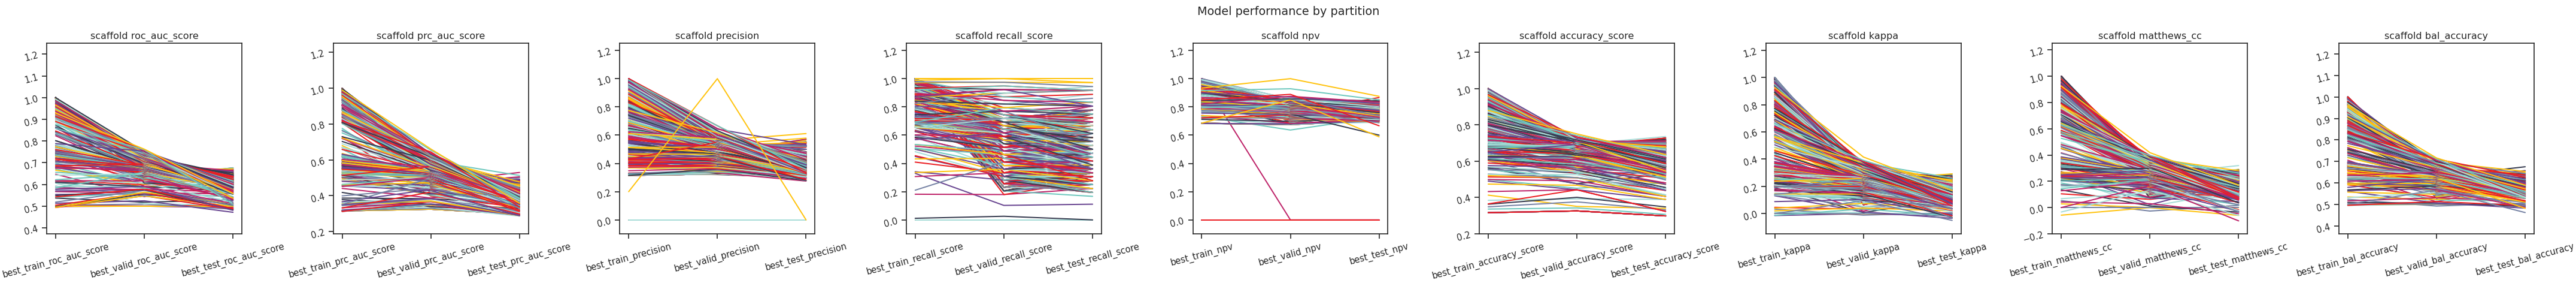

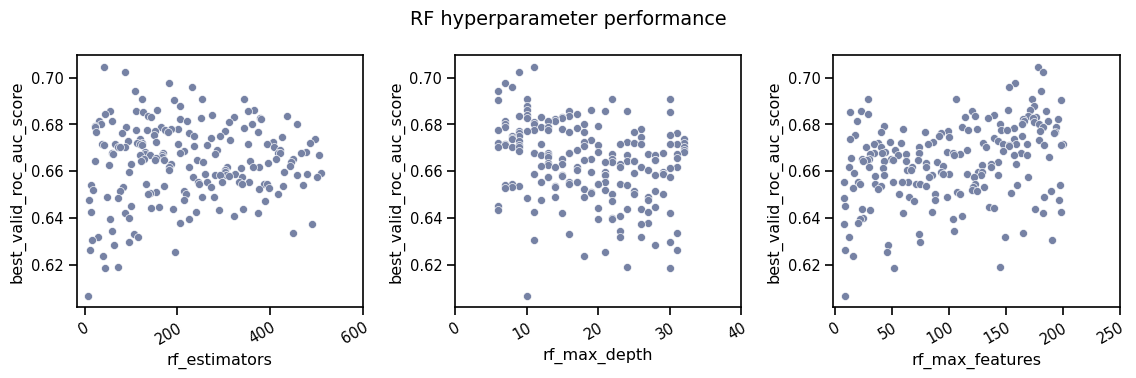

In [26]:
hpp.plot_train_valid_test_scores(result_df, prediction_type='classification')

hpp.plot_hyper_perf(result_df, model_type='RF', subset='valid', scoretype='roc_auc_score')

## Examples of Other Parameter Sets
Below are some parameters that can be used for **neural networks**, 
**[XGBoost](https://en.wikipedia.org/wiki/XGBoost)** models, 
**fingerprint splits** and **[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t)** features.
Each set of parameters can be used to replace the parameters above. 
Trying them out is left as an exercise for the reader.

#### Neural Network Hyperopt Search

|Parameter|Description|
|---|---|
|`lr`| This controls the learning rate. loguniform\|-13.8,-3 means the logarithm of the learning rate is uniformly distributed between -13.8 and -3.|
|`ls` |This controls layer sizes. 3\|8,512 means 3 layers with sizes ranging between 8 and 512 neurons. A good strategy is to start with a fewer layers and slowly increase the number until performance plateaus.| 
|`dp`| This controls dropout. 3\|0,0.4 means 3 dropout layers with probability of zeroing a weight between 0 and 40%. This needs to match the number of layers specified with `ls` and should range between 0% and 50%. |
|`max_epochs`| This controls how long to train each model. Training for more epochs increases runtime, but allows models more time to optimize. |

In [21]:
nn_params = {
    "hyperparam": "True",
    "prediction_type": "classification",

    "dataset_key": dataset_key,
    "id_col": "compound_id",
    "smiles_col": "base_rdkit_smiles",
    # "response_cols": "avg_pKi",

    "splitter": "scaffold",
    "split_uuid": split_uuid,
    "previously_split": "True",

    "featurizer": "computed_descriptors",
    "descriptor_type" : descriptor_type,
    "transformers": "True",
    "previously_featurized": "True",

    ### Use a NN model
    "search_type": "hyperopt",
    "model_type": "NN|100",
    "lr": "loguniform|-13.8,-3", # e^-13.8 to e^-3
    "ls": "uniformint|3|8,512",
    "dp": "uniform|3|0,0.4",
    "max_epochs":100,
    ###
    "weight_transform_type": "balancing",
    # "class_number":3,
    # "result_dir": f"./{best_model_dir},./{model_dir}"
}

#### XGBoost
- `xgbg` Stands for `xgb_gamma` and controls the minimum loss 
reduction required to make a further partition on a leaf node of the tree.
- `xgbl` Stands for `xgb_learning_rate` and controls the boosting 
learning rate searching domain of  **[XGBoost](https://en.wikipedia.org/wiki/XGBoost)** models.

In [18]:
xg_params = {
    "hyperparam": "True",
    "prediction_type": "classification",

    "dataset_key": dataset_key,
    "id_col": "compound_id",
    "smiles_col": "base_rdkit_smiles",
    # "response_cols": "avg_pKi",

    "splitter":"scaffold",
    "split_uuid": split_uuid,
    "previously_split": "True",

    "featurizer": "computed_descriptors",
    "descriptor_type" : descriptor_type,
    "transformers": "True",
    "previously_featurized": "True",


    ### Use an XGBoost model
    "search_type": "hyperopt",
    "model_type": "xgboost|200",
    "xgbg": "uniform|0,0.2", # gamma
    "xgbn": "uniformint|8,512", # num_estimators
    "xgbd": "uniformint|2,8", # max_depth
    "xgbw": "uniform|0.1,3", # min_child_weight
    "xgbl": "loguniform|-5,0", # learning rate
    "xgbc": "uniform|0.2,1.0", # colsample_bytree
    "xgbs": "uniform|0.2,1.0", # subsample
    ###

    "weight_transform_type": "balancing",
    # "result_dir": f"./{best_model_dir},./{model_dir}"
}

#### Fingerprint Split
This trains an  **[XGBoost](https://en.wikipedia.org/wiki/XGBoost)** model using a
**fingerprint split**. The fingerprint split is provided with the dataset files. 

In [ ]:
fp_split_uuid="be60c264-6ac0-4841-a6b6-41bf846e4ae4"

fp_params = {
    "hyperparam": "True",
    "prediction_type": "regression",

    "dataset_key": dataset_key,
    "id_col": "compound_id",
    "smiles_col": "base_rdkit_smiles",
    "response_cols": "avg_pKi",

    ### Use a fingerprint split
    "splitter":"fingerprint",
    "split_uuid": fp_split_uuid,
    "previously_split": "True",
    ###

    "featurizer": "computed_descriptors",
    "descriptor_type" : descriptor_type,
    "transformers": "True",

    "search_type": "hyperopt",
    "model_type": "xgboost|10",
    "xgbg": "uniform|0,0.2",
    "xgbl": "loguniform|-2,2",

    "result_dir": f"./{best_model_dir},./{model_dir}"
}

#### ECFP Features
This uses an  **[XGBoost](https://en.wikipedia.org/wiki/XGBoost)** model with **[ECFP fingerprints](https://pubs.acs.org/doi/10.1021/ci100050t)** features and a **scaffold split**.

In [ ]:
ec_params = {
    "hyperparam": "True",
    "prediction_type": "regression",

    "dataset_key": dataset_key,
    "id_col": "compound_id",
    "smiles_col": "base_rdkit_smiles",
    "response_cols": "avg_pKi",

    "splitter":"scaffold",
    "split_uuid": split_uuid,
    "previously_split": "True",

    ### Use ECFP Features
    "featurizer": "ecfp",
    "ecfp_radius" : 2,
    "ecfp_size" : 1024,
    "transformers": "True",
    ###

    "search_type": "hyperopt",
    "model_type": "xgboost|10",
    "xgbg": "uniform|0,0.2",
    "xgbl": "loguniform|-2,2",

    "result_dir": f"./{best_model_dir},./{model_dir}"
}

In **Tutorial 6, "Compare Models to Select the Best Hyperparameters"**, we analyze the performance of these large sets of models to select the best hyperparameters for production models.

If you have specific feedback about a tutorial, please complete the **[AMPL Tutorial Evaluation](https://forms.gle/pa9sHj4MHbS5zG7A6)**.